# Netflix Dataset Exploratoy Analysis

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

## Fetch data

In [2]:
df = pd.read_csv('netflix_titles.csv')

In [3]:
df.sample()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7286,s7287,TV Show,Two Fathers,NaN,"Weber Yang, Lin Yo-Wei, Megan Lai, Amanda Chou...",Taiwan,"August 1, 2016",2013,TV-14,1 Season,"International TV Shows, Romantic TV Shows, TV ...",When two single guys learn a woman they both s...


## Clean data

Lets first check how many rows the dataset has

In [4]:
df.shape

(7787, 12)

### Does it have null values?

In [5]:
df.isna().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

Yes, let's fill them or discard them to avoid further problems

Fill string columns with default value

In [6]:
df.director.fillna(value='N/A', inplace=True)
df.cast.fillna(value='N/A', inplace=True)
df.country.fillna(value='N/A', inplace=True)
df.rating.fillna(value='N/A', inplace=True)

It has 10 rows left with null values of dates. Since they are a few and I want this column to be a date type to make it easier to plot later I will just drop them.

In [7]:
df.dropna(inplace=True)

You should always be carefull dropping null values, you don't want to drop more than you should. So let's double check I didn't

In [8]:
df.shape

(7777, 12)

### Let's create some usefull columns

Depending on the type of show, we found 2 different ways to describe the duration of the show. If it's a movie its duration is in minutes and if it is a tv show the duration is in seasons. Let's check a few examples:

In [9]:
df[df.type=='Movie'].sample(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
3845,s3846,Movie,Maddman: The Steve Madden Story,Ben Patterson,Steve Madden,United States,"January 1, 2018",2017,TV-MA,78 min,Documentaries,This documentary chronicles the rise of the fo...
6136,s6137,Movie,The Black Godfather,Reginald Hudlin,"Clarence Avant, Quincy Jones",United States,"June 7, 2019",2019,TV-MA,118 min,"Documentaries, Music & Musicals",This documentary follows the life of Clarence ...


In [10]:
df[df.type=='TV Show'].sample(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
4156,s4157,TV Show,Mob Psycho 100,N/A,"Tatsuomi Hamada, Kazuki Namioka, Yuki Yoda, Ay...",Japan,"May 22, 2018",2018,TV-MA,1 Season,"International TV Shows, TV Action & Adventure,...",There's an organization gathering espers for a...
3573,s3574,TV Show,Legend Quest: Masters of Myth,N/A,"Johnny Rose, Annemarie Blanco, Paul Tei, Oscar...",Mexico,"October 5, 2019",2019,TV-Y7,1 Season,Kids' TV,"When mythical creatures come to life, it's up ..."


Let's build some integer columns with the duration in minutes or in seasons depending on the kind of show:

In [11]:
df['duration_min'] = df.duration.apply(lambda x: int(x[:-4]) if 'min' in x else None)
df['duration_seasons'] = df.duration.apply(lambda x: int(x[:-8]) if 'Seasons' in x else None)

The dataset has the date the show was added to Netflix and the year of the release of the show. Let's add a column to explore this difference then:

In [12]:
def string_to_date(string_date: object) -> datetime.date:
    """
    Convert an string date with the format September 20, 2019 to a datetime object

    :returns:
       datetime
    """
    datetime_date = datetime.strptime(string_date.strip(),"%B %d, %Y")
    return datetime_date

In [13]:
df['date_added'] = df.date_added.apply(string_to_date)
df['year_added'] = df.date_added.apply(lambda x: x.year)
df['month_year_added'] = df.date_added.dt.strftime('%Y-%m')

In [14]:
df['diff_added_release'] = df.year_added - df.release_year

In [15]:
df['show_age'] = datetime.now().year - df.release_year

## Explore data

### How many movies and how many TV Show do we have?

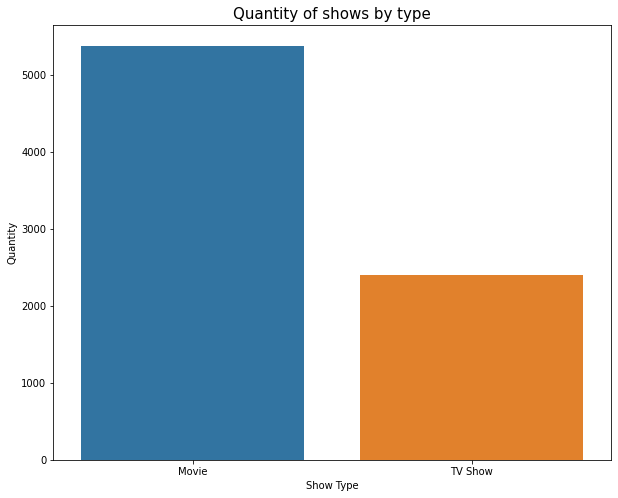

In [16]:
df_aux = df.groupby('type').show_id.count().reset_index()
plt.figure(figsize=(10,8))
sns.barplot(data = df_aux,
            x = 'type',
            y = 'show_id').set(xlabel='Show Type', 
                               ylabel='Quantity');
plt.title('Quantity of shows by type', size=15);

**Netflix's Catalog has more movies than tv shows, almost twice times movies than shows**

### How does the catalog evolve in time? How many new shows are added each month?

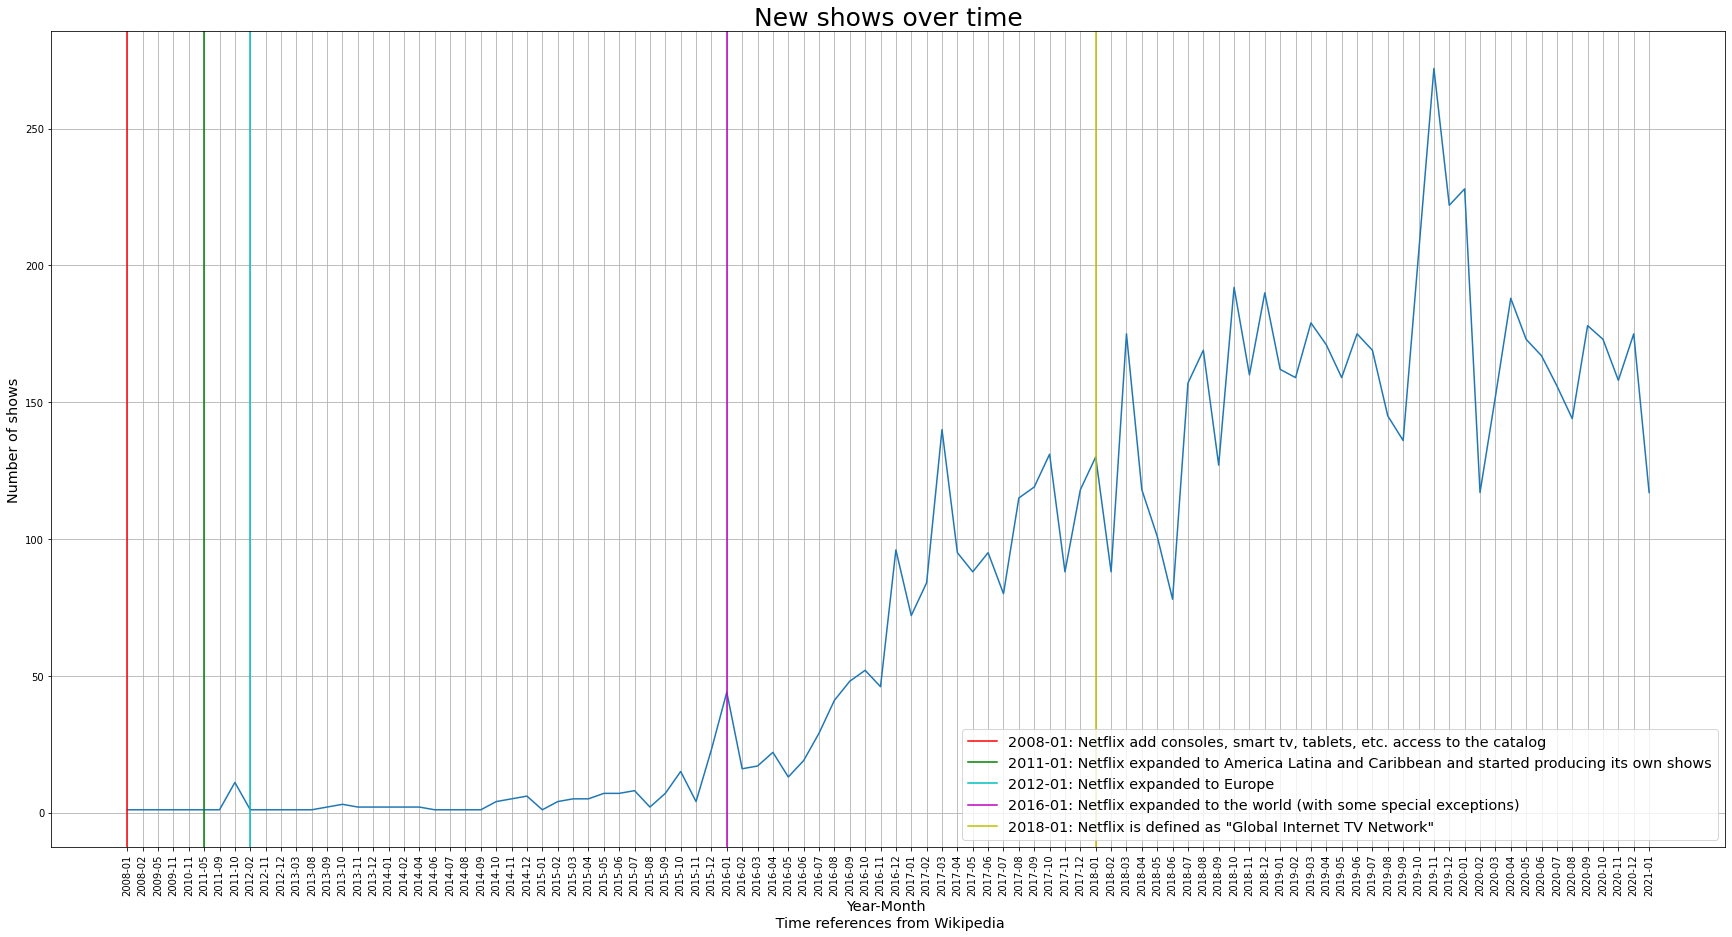

In [17]:
df_aux = df.groupby(by=['month_year_added']).show_id.count().reset_index()
plt.figure(figsize=(30,15))
plt.grid();
sns.lineplot(data = df_aux,
            x = 'month_year_added',
            y='show_id');
plt.xlabel(xlabel='Year-Month \n Time references from Wikipedia', fontsize='x-large')
plt.ylabel(ylabel='Number of shows', fontsize='x-large')

plt.xticks(rotation=90);
plt.axvline('2008-01', color='r', label='2008-01: Netflix add consoles, smart tv, tablets, etc. access to the catalog');
plt.axvline('2011-05', color='g', label='2011-01: Netflix expanded to America Latina and Caribbean and started producing its own shows');
plt.axvline('2012-02', color='c', label='2012-01: Netflix expanded to Europe');
plt.axvline('2016-01', color='m', label='2016-01: Netflix expanded to the world (with some special exceptions)');
plt.axvline('2018-01', color='y', label='2018-01: Netflix is defined as "Global Internet TV Network"');
plt.legend(fontsize='x-large');
plt.title('New shows over time', fontsize=25);

In [18]:
df.groupby(by=['month_year_added']).show_id.count().reset_index().describe()

,show_id
count,100.00000
mean,77.77000
std,75.34766
min,1.00000
25%,3.75000
50%,62.00000
75%,153.00000
max,272.00000


In [19]:
df_aux[df_aux.show_id==272]

,month_year_added,show_id
85,2019-11,272


Summary
- Half of the times, Netflix uploads (at least) **62** new shows to its catalog each month
- The period in which they added the most quantity of shows (**272**) was **2019-11** (Really convinient for the pandemic right?)
- In average, Netflix adds **78** new shows every month

There are a lot of more questions that can be ask and answer with this dataset. But for today this is all. Thanks for reading!